<a href="https://colab.research.google.com/github/siminghasemi/Machin_Learning_2024/blob/main/predictive_maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive Maintenance

This notebook is part of [*Practical Data Science for IoT*](https://github.com/pablodecm/datalab_ml_iot) tutorial by Pablo de Castro

## Tools

This notebook will use the following Python 3
libraries for data analytics and machine learning:
- pandas
- numpy
- matplotlib
- scikit-learn
- keras/tensorflow

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Dataset

The dataset that will be used, which was published by NASA [[3](#References)],
consist on simulated turbojet engine degradation
under different combinations of operational conditions.

**The main task is to predict when the engine is about to fail before it fails.**

<div align="center">
  <img src="https://github.com/pablodecm/datalab_ml_iot/blob/master/01_predictive_maintenance/images/airbus-turbofan.jpg?raw=1" height="50%" style="max-width: 50%">
</div>


In [5]:
!mkdir data
!wget https://phm-datasets.s3.amazonaws.com/NASA/6.+Turbofan+Engine+Degradation+Simulation+Data+Set.zip -O data/CMAPSSData.zip
!unzip -o data/CMAPSSData.zip -d data

--2025-06-08 11:57:12--  https://phm-datasets.s3.amazonaws.com/NASA/6.+Turbofan+Engine+Degradation+Simulation+Data+Set.zip
Resolving phm-datasets.s3.amazonaws.com (phm-datasets.s3.amazonaws.com)... 52.216.63.1, 3.5.28.213, 54.231.199.145, ...
Connecting to phm-datasets.s3.amazonaws.com (phm-datasets.s3.amazonaws.com)|52.216.63.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12429152 (12M) [application/zip]
Saving to: ‘data/CMAPSSData.zip’

data/CMAPSSData.zip 100%[===================>]  11.85M  23.7MB/s    in 0.5s    

2025-06-08 11:57:12 (23.7 MB/s) - ‘data/CMAPSSData.zip’ saved [12429152/12429152]

Archive:  data/CMAPSSData.zip
   creating: data/6. Turbofan Engine Degradation Simulation Data Set/
  inflating: data/6. Turbofan Engine Degradation Simulation Data Set/CMAPSSData.zip  


In [6]:
!unzip -o data/'6. Turbofan Engine Degradation Simulation Data Set/CMAPSSData.zip' -d data

Archive:  data/6. Turbofan Engine Degradation Simulation Data Set/CMAPSSData.zip
  inflating: data/Damage Propagation Modeling.pdf  
  inflating: data/readme.txt         
  inflating: data/RUL_FD001.txt      
  inflating: data/RUL_FD002.txt      
  inflating: data/RUL_FD003.txt      
  inflating: data/RUL_FD004.txt      
  inflating: data/test_FD001.txt     
  inflating: data/test_FD002.txt     
  inflating: data/test_FD003.txt     
  inflating: data/test_FD004.txt     
  inflating: data/train_FD001.txt    
  inflating: data/train_FD002.txt    
  inflating: data/train_FD003.txt    
  inflating: data/train_FD004.txt    


In [7]:
# this converts the encoding
!iconv -f ISO-8859-1 -t UTF-8//TRANSLIT data/readme.txt > data/readme_enc.txt
!cat  data/readme_enc.txt

Data Set: FD001
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: ONE (HPC Degradation)

Data Set: FD002
Train trjectories: 260
Test trajectories: 259
Conditions: SIX 
Fault Modes: ONE (HPC Degradation)

Data Set: FD003
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: TWO (HPC Degradation, Fan Degradation)

Data Set: FD004
Train trjectories: 248
Test trajectories: 249
Conditions: SIX 
Fault Modes: TWO (HPC Degradation, Fan Degradation)



Experimental Scenario

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine  i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. Th

In [8]:
# train and test data are simple space separated values
!head -5 data/train_FD001.txt

1 1 -0.0007 -0.0004 100.0 518.67 641.82 1589.70 1400.60 14.62 21.61 554.36 2388.06 9046.19 1.30 47.47 521.66 2388.02 8138.62 8.4195 0.03 392 2388 100.00 39.06 23.4190  
1 2 0.0019 -0.0003 100.0 518.67 642.15 1591.82 1403.14 14.62 21.61 553.75 2388.04 9044.07 1.30 47.49 522.28 2388.07 8131.49 8.4318 0.03 392 2388 100.00 39.00 23.4236  
1 3 -0.0043 0.0003 100.0 518.67 642.35 1587.99 1404.20 14.62 21.61 554.26 2388.08 9052.94 1.30 47.27 522.42 2388.03 8133.23 8.4178 0.03 390 2388 100.00 38.95 23.3442  
1 4 0.0007 0.0000 100.0 518.67 642.35 1582.79 1401.87 14.62 21.61 554.45 2388.11 9049.48 1.30 47.13 522.86 2388.08 8133.83 8.3682 0.03 392 2388 100.00 38.88 23.3739  
1 5 -0.0019 -0.0002 100.0 518.67 642.37 1582.85 1406.22 14.62 21.61 554.00 2388.06 9055.15 1.30 47.28 522.19 2388.04 8133.80 8.4294 0.03 393 2388 100.00 38.90 23.4044  


In [9]:
# train and test data are simple space separated values
!head -5 data/test_FD001.txt

1 1 0.0023 0.0003 100.0 518.67 643.02 1585.29 1398.21 14.62 21.61 553.90 2388.04 9050.17 1.30 47.20 521.72 2388.03 8125.55 8.4052 0.03 392 2388 100.00 38.86 23.3735  
1 2 -0.0027 -0.0003 100.0 518.67 641.71 1588.45 1395.42 14.62 21.61 554.85 2388.01 9054.42 1.30 47.50 522.16 2388.06 8139.62 8.3803 0.03 393 2388 100.00 39.02 23.3916  
1 3 0.0003 0.0001 100.0 518.67 642.46 1586.94 1401.34 14.62 21.61 554.11 2388.05 9056.96 1.30 47.50 521.97 2388.03 8130.10 8.4441 0.03 393 2388 100.00 39.08 23.4166  
1 4 0.0042 0.0000 100.0 518.67 642.44 1584.12 1406.42 14.62 21.61 554.07 2388.03 9045.29 1.30 47.28 521.38 2388.05 8132.90 8.3917 0.03 391 2388 100.00 39.00 23.3737  
1 5 0.0014 0.0000 100.0 518.67 642.51 1587.19 1401.92 14.62 21.61 554.16 2388.01 9044.55 1.30 47.31 522.15 2388.03 8129.54 8.4031 0.03 390 2388 100.00 38.99 23.4130  


In [10]:
# the test truth is given as the number of steps to failure
# for each engine run in the test set (100 in total)
!head -5 data/RUL_FD001.txt

112 
98 
69 
82 
91 


In [11]:
# load data (only gonna use FD001 dataset)
train_df = pd.read_csv('data/train_FD001.txt', sep=" ", header=None)
test_df  = pd.read_csv('data/test_FD001.txt', sep=" ", header=None)
print("train shape: ", train_df.shape, "test shape: ", test_df.shape)
# lets have a look at basic descriptive statistics
train_df.describe()

train shape:  (20631, 28) test shape:  (13096, 28)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,0.0,0.0
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,NaN,NaN
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251,NaN,NaN
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,NaN,NaN
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,NaN,NaN
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,NaN,NaN
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,NaN,NaN
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,NaN,NaN


In [12]:
# we will remove columns 26 and 27 because of the NaNs
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
print("train shape: ", train_df.shape, "test shape: ", test_df.shape)

train shape:  (20631, 26) test shape:  (13096, 26)


In [13]:
# the files did not contain headers
# we can create them based on the documentation
target_var = ['target_RUL']
index_columns_names =  ["UnitNumber","Cycle"]
op_settings_columns = ["Op_Setting_"+str(i) for i in range(1,4)]
sensor_columns =["Sensor_"+str(i) for i in range(1,22)]
column_names = index_columns_names + op_settings_columns + sensor_columns
print(column_names)

['UnitNumber', 'Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3', 'Sensor_1', 'Sensor_2', 'Sensor_3', 'Sensor_4', 'Sensor_5', 'Sensor_6', 'Sensor_7', 'Sensor_8', 'Sensor_9', 'Sensor_10', 'Sensor_11', 'Sensor_12', 'Sensor_13', 'Sensor_14', 'Sensor_15', 'Sensor_16', 'Sensor_17', 'Sensor_18', 'Sensor_19', 'Sensor_20', 'Sensor_21']


In [14]:
# name columns
train_df.columns = column_names
test_df.columns = column_names

# now the dataset looks better, e.g. the first unit
train_df[train_df.UnitNumber == 1].head(5)

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


### Remaining Useful Life (RUL)

The training data consists time-series for the engine sensors
for each cycle (i.e. timestep) until failure which happens
after the last time step.

Thus, the Remaining Useful Life (RUL), i.e. time until the
engine breaks, can be calculated based on the maximum cycle
of each unit present in the training set.


In [15]:
# find the last cycle per unit number
max_cycle = train_df.groupby('UnitNumber')['Cycle'].max().reset_index()
max_cycle.columns = ['UnitNumber', 'MaxOfCycle']
print(max_cycle.head(5))
print(max_cycle.shape)

# merge the max cycle back into the original frame
train_df = train_df.merge(max_cycle, left_on='UnitNumber', right_on='UnitNumber', how='inner')
train_df.head(5)

# calculate RUL for each row
target_RUL = train_df["MaxOfCycle"] - train_df["Cycle"]
# add columns and remove MaxOfCycle
train_df["target_RUL"] = target_RUL
train_df = train_df.drop("MaxOfCycle", axis=1)
# check that it worked for unit 1
train_df[train_df.UnitNumber == 1].head(5)

   UnitNumber  MaxOfCycle
0           1         192
1           2         287
2           3         179
3           4         189
4           5         269
(100, 2)


,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,target_RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


The test data does not correspond to running until failure
as discussed in the dataset documentation, the RUL at the last
step is instead provided on an additional file.

In [17]:
# get truth RUL
truth_df = pd.read_csv('data/RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

# UnitNumber based
truth_df.columns = ["RUL_after_last"]
truth_df['UnitNumber'] =  truth_df.index + 1
print(truth_df.head(5))
print(truth_df.shape)

# find the last cycle per unit number in test set
max_cycle = test_df.groupby('UnitNumber')['Cycle'].max().reset_index()
max_cycle.columns = ['UnitNumber', 'MaxOfCycle']
max_cycle['MaxOfCycle'] = max_cycle['MaxOfCycle'] + truth_df["RUL_after_last"]

# merge the max cycle back into the original frame
test_df = test_df.merge(max_cycle, left_on='UnitNumber', right_on='UnitNumber', how='inner')
# calculate RUL for each row
target_RUL = test_df["MaxOfCycle"] - test_df["Cycle"]
# add columns and remove MaxOfCycle
test_df["target_RUL"] = target_RUL
test_df = test_df.drop("MaxOfCycle", axis=1)
# check that it worked for unit 1
test_df[test_df.UnitNumber == 1].head(5)

   RUL_after_last  UnitNumber
0             112           1
1              98           2
2              69           3
3              82           4
4              91           5
(100, 2)


,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,target_RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


### Defining the Problem

**The first step before starting with ML for a IoT application (or any problem for that matter)
is to understand well the task at hand.**

Predictive maintenance is about having accurate predictions (based on sensors or performances)
of when a machine or a industrial setup will fail and how to schedule costly maintenance
intelligently and reduce operating costs.

The most common problem definitions for predictive maintenance are:

- Regression (**included here**): Predict the Remaining Useful Life (RUL) or Time to Failure (TTF).
- Binary classification (**included here**): Predict if an asset will fail within certain time frame (e.g. days).
- Multi-class classification (**not included here**): Predict if an asset will fail in different time windows or due to different failure models


These techniques are those also used for general time-series
forecasting but at application time we do not have access to the target value at the current or
previous time step.



### Feature Exploration

Independently on the chosen problem, it is always recommended
to interactively explore the variables to be considered
in the predictive modelling problem.

It is important to not only consider the data available
in the training set but also that expected in the test
or production environment. Alternatively we can
incur in:
- **target leakage**: use information that has predictive power
as input of the model during training but will no be available
in production or for the real data.
- **domain mismatch**: if the training and test/production data
are different the trained models might not perform well in
the real word scenario.

In [18]:
# we will consider all features except the UnitNumber and the target
basic_features = train_df.columns.difference(["UnitNumber","target_RUL"])
print("basic_features: ",basic_features)

basic_features:  Index(['Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3', 'Sensor_1',
       'Sensor_10', 'Sensor_11', 'Sensor_12', 'Sensor_13', 'Sensor_14',
       'Sensor_15', 'Sensor_16', 'Sensor_17', 'Sensor_18', 'Sensor_19',
       'Sensor_2', 'Sensor_20', 'Sensor_21', 'Sensor_3', 'Sensor_4',
       'Sensor_5', 'Sensor_6', 'Sensor_7', 'Sensor_8', 'Sensor_9'],
      dtype='object')


#### Exercise: Plot the Sensor Data for given Unit

For a given unit of the training set, plot the time-series of some of the sensor data.

Max Cycle: 192


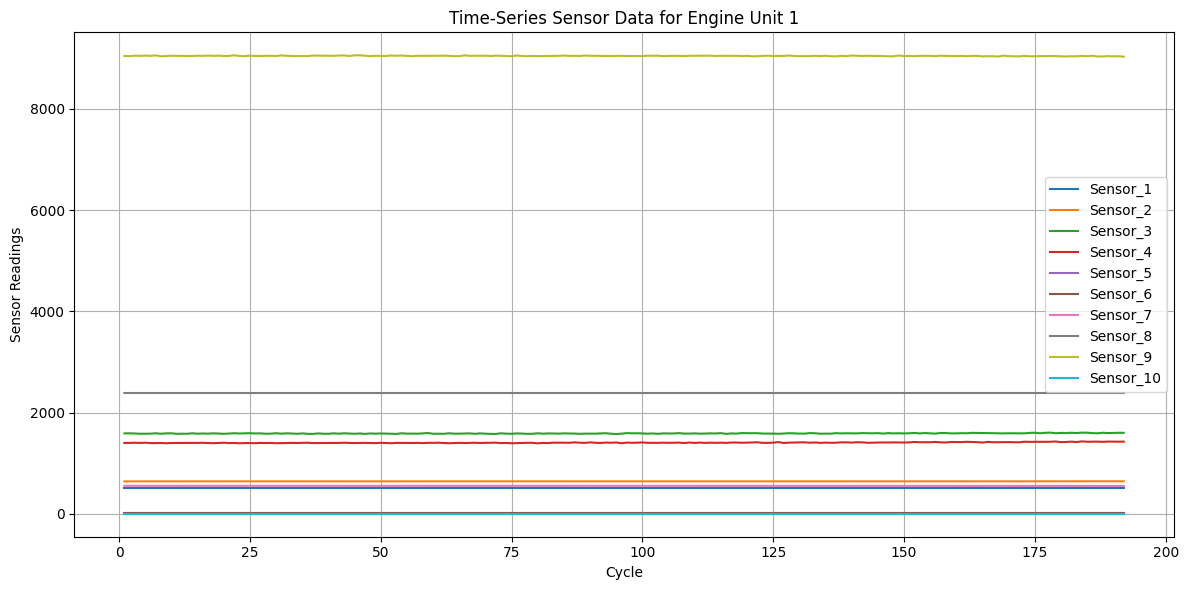

In [19]:
# space for exercise solution

# Filter data for a specific engine unit, e.g., engine_id = 1
unit_id = 1
unit_data = train_df[train_df['UnitNumber'] == unit_id]

# Set 'Cycle' as the time axis
time = unit_data['Cycle']
print("Max Cycle:" , time.max())

# Choose some sensors to plot
sensors_to_plot = ['Sensor_1', 'Sensor_2', 'Sensor_3', 'Sensor_4', 'Sensor_5', 'Sensor_6', 'Sensor_7', 'Sensor_8', 'Sensor_9', 'Sensor_10']

# Plot
plt.figure(figsize=(12, 6))
for sensor in sensors_to_plot:
    plt.plot(time, unit_data[sensor], label=sensor)

plt.title(f'Time-Series Sensor Data for Engine Unit {unit_id}')
plt.xlabel('Cycle')
plt.ylabel('Sensor Readings')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Exercise: Compare the Distribution of Variables in the Train and Test sets

Compare graphically the distribution of some of the
input variables (e.g. 'Cycle', 'Op_Setting_1' or sensor data) for the train and test sets.

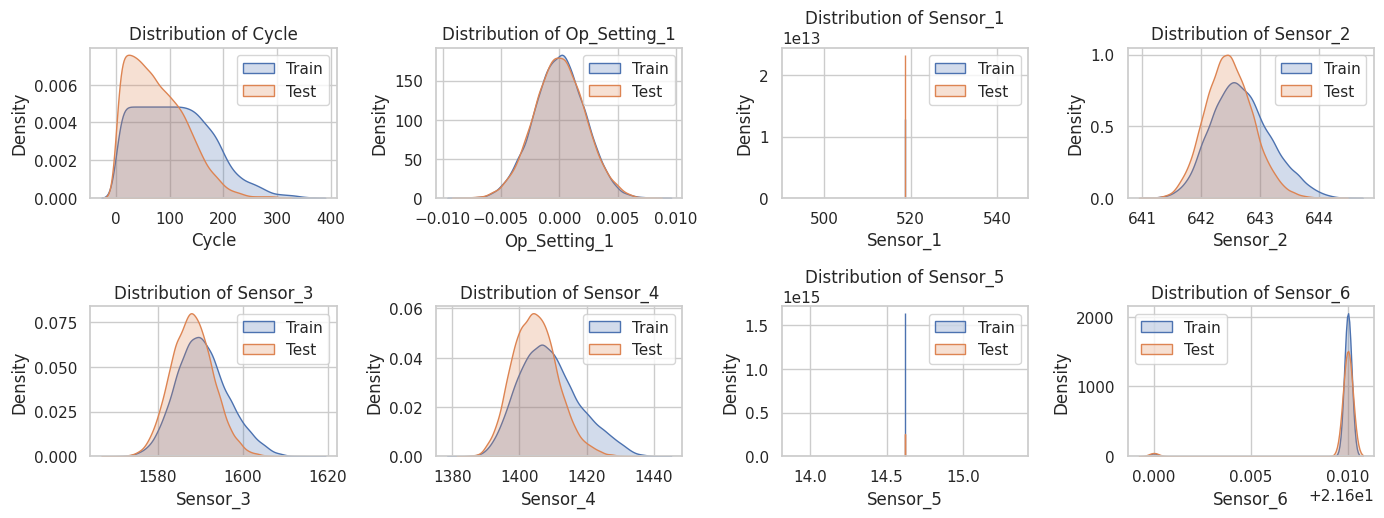

In [20]:
# space for exercise solution

import seaborn as sns

# Variables to compare
features_to_compare = ['Cycle', 'Op_Setting_1', 'Sensor_1', 'Sensor_2', 'Sensor_3', 'Sensor_4', 'Sensor_5', 'Sensor_6']

# Set style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(14, 10))
for i, feature in enumerate(features_to_compare, 1):
    plt.subplot(4, 4, i)
    sns.kdeplot(train_df[feature], label='Train', fill=True, common_norm=False)
    sns.kdeplot(test_df[feature], label='Test', fill=True, common_norm=False)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()


#### Exercise: Compare the Distrubution of the Target in the Train and Test sets

Compare graphically the distribution of the target RUL in the train and test sets.
Will this affect the training? How could it be avoided (see reference [9](#References))

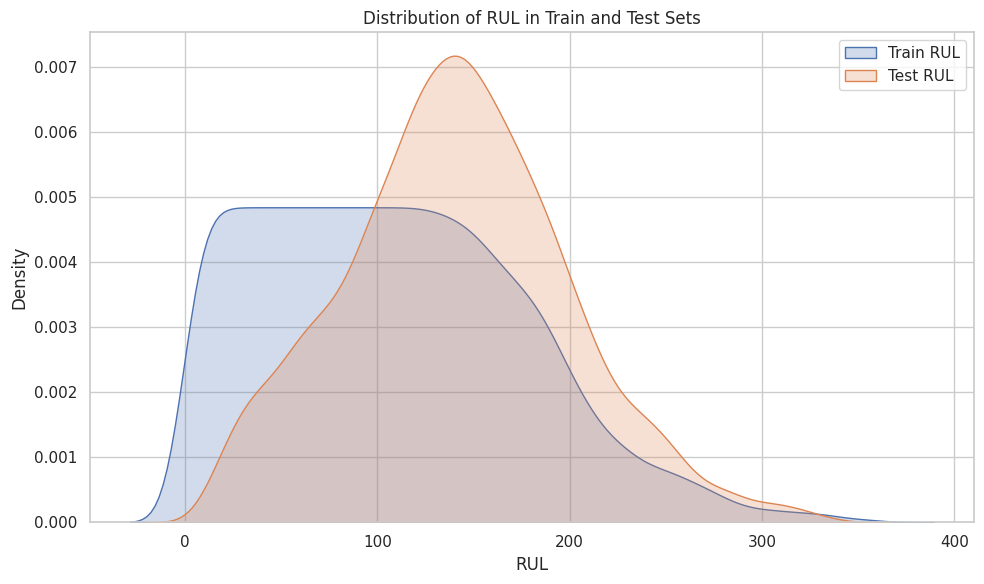

In [21]:
# space for exercise solution

# Set style
sns.set(style="whitegrid")

# Plot RUL distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(train_df['target_RUL'], label='Train RUL', fill=True, common_norm=False)
sns.kdeplot(test_df['target_RUL'], label='Test RUL', fill=True, common_norm=False)
plt.title('Distribution of RUL in Train and Test Sets')
plt.xlabel('RUL')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Feature Transformations and Engineering

Another important step, particularly when dealing with
most techniques other than Deep Learning, is *feature
preprocessing/scaling* and *feature engineering*.

Feature preprocessing/scaling can facilitate model training by
scaling the features to dimensionless values based on the properties
of the dataset.

Feature engineering, the definition of new variables based
on those available, is particularly important for time-series
data when we want to
make a prediction for each timestep as is the case for all the
problems considered in this notebook.




In [22]:
from sklearn import preprocessing

# we will use the Standard Scaler
scaler = preprocessing.StandardScaler()

features = basic_features
X_unscaled = train_df[features].astype('float64')
X = pd.DataFrame(scaler.fit_transform(X_unscaled),
                 columns = features,
                 index = train_df.index)
y = train_df["target_RUL"]

X.describe()

,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,...,Sensor_2,Sensor_20,Sensor_21,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9
count,2.063100e+04,2.063100e+04,2.063100e+04,20631.0,20631.0,20631.0,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,...,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04
mean,-8.816778e-17,1.377622e-18,-2.720802e-17,0.0,0.0,0.0,-2.937089e-15,-1.199702e-13,3.493855e-13,3.061075e-15,...,6.410348e-14,4.156146e-14,2.402296e-14,-4.959437e-14,9.285169e-16,-1.776357e-15,-6.469426e-12,-3.161641e-14,1.008249e-12,-4.185765e-14
std,1.000024e+00,1.000024e+00,1.000024e+00,0.0,0.0,0.0,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,...,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,0.000000e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00
min,-1.565170e+00,-3.973523e+00,-2.055419e+00,0.0,0.0,0.0,-2.587860e+00,-3.692663e+00,-3.005574e+00,-2.296780e+00,...,-2.941625e+00,-3.741634e+00,-3.653688e+00,-3.177804e+00,-2.964737e+00,-1.776357e-15,-7.057993e+00,-3.974497e+00,-2.770375e+00,-1.970486e+00
25%,-8.247448e-01,-6.817340e-01,-6.904875e-01,0.0,0.0,0.0,-7.157686e-01,-6.148450e-01,-7.807925e-01,-5.508429e-01,...,-7.118085e-01,-6.432961e-01,-6.273114e-01,-6.953381e-01,-7.303888e-01,-1.776357e-15,1.416833e-01,-6.301317e-01,-6.572157e-01,-5.498936e-01
50%,-6.980124e-02,4.055368e-03,-8.021809e-03,0.0,0.0,0.0,-1.166993e-01,9.020580e-02,-8.554830e-02,-1.684195e-01,...,-8.186036e-02,7.596096e-02,7.570228e-02,-6.901297e-02,-9.930481e-02,-1.776357e-15,1.416833e-01,8.167571e-02,-9.370652e-02,-2.075387e-01
75%,6.851423e-01,6.898448e-01,1.015677e+00,0.0,0.0,0.0,5.946956e-01,7.274632e-01,6.096959e-01,2.389047e-01,...,6.380804e-01,7.398906e-01,7.122022e-01,6.290786e-01,6.245530e-01,-1.776357e-15,1.416833e-01,7.256920e-01,6.106800e-01,1.891583e-01
max,3.675880e+00,3.981634e+00,2.039375e+00,0.0,0.0,0.0,3.702368e+00,2.666353e+00,6.449748e+00,7.861686e+00,...,3.697829e+00,3.395609e+00,3.036489e+00,4.303846e+00,3.617202e+00,-1.776357e-15,1.416833e-01,3.041891e+00,6.527526e+00,8.121740e+00


In [23]:
X_test_unscaled = test_df[features].astype('float64')
X_test = pd.DataFrame(scaler.transform(X_test_unscaled),
                      columns = features,
                      index = test_df.index)
y_test = test_df["target_RUL"]

X_test.describe()

,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,...,Sensor_2,Sensor_20,Sensor_21,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9
count,13096.000000,13096.000000,13096.000000,13096.0,13096.0,13096.0,13096.000000,13096.000000,13096.000000,13096.000000,...,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,1.309600e+04,13096.000000,13096.000000,13096.000000,13096.000000
mean,-0.464165,-0.001056,0.006439,0.0,0.0,0.0,-0.467888,0.453204,-0.349397,-0.251886,...,-0.411658,0.421766,0.425294,-0.395354,-0.466471,-1.776357e-15,-0.073823,0.440430,-0.361875,-0.309549
std,0.770300,1.007052,1.003329,0.0,0.0,0.0,0.733550,0.758779,0.791665,0.534114,...,0.801733,0.783884,0.777105,0.816062,0.743114,0.000000e+00,1.226886,0.769753,0.809224,0.517892
min,-1.565170,-3.744927,-2.055419,0.0,0.0,0.0,-2.775070,-2.757115,-2.866525,-1.848042,...,-3.101612,-2.801067,-3.273082,-3.504015,-2.726970,-1.776357e-15,-7.057993,-2.810748,-2.911252,-1.843687
25%,-1.100590,-0.681734,-0.690488,0.0,0.0,0.0,-1.015303,-0.045381,-0.919841,-0.599858,...,-0.966788,-0.090021,-0.074878,-0.966093,-0.998155,-1.776357e-15,0.141683,-0.065205,-0.938970,-0.644087
50%,-0.577936,0.004055,-0.008022,0.0,0.0,0.0,-0.491118,0.496966,-0.363646,-0.281128,...,-0.441831,0.463253,0.457233,-0.413166,-0.499288,-1.776357e-15,0.141683,0.488423,-0.375461,-0.358791
75%,0.060862,0.689845,1.015677,0.0,0.0,0.0,-0.004374,0.998637,0.192549,0.031835,...,0.118123,0.961200,0.959781,0.136908,0.012913,-1.776357e-15,0.141683,0.985558,0.188048,-0.051305
max,2.819310,3.570160,2.380608,0.0,0.0,0.0,2.691438,3.181582,3.112575,4.022249,...,3.237866,3.284954,3.253583,2.777178,2.713908,-1.776357e-15,0.141683,2.793323,2.864717,4.066011


### RUL Prediction as a Regression Task

**How many more cycles an in-service engine will last before it fails?**

The task of predicting the Remaining Useful Life (RUL)
can be casted as a regression task in the context of machine
learning. RUL can also be referred as Time to Failure (TTF).


The goal in a regression problem is to find a function
$f_R(\boldsymbol{x})$ that approximates the true target $y$. The
target in this problem will be the RUL, while $\boldsymbol{x}$
will be the input features (e.g. sensor readings).

To measure the goodness of our regression function, we need
to define and score function, which will be also the loss
function for some of the machine learning techniques considered.
We will be considering the mean squared error:
$$ \textrm{MSE} = \sum_{i=1}^{n} (y - f_R(\boldsymbol{x}))^2$$
which is one of the most common losses used for regression,
depending on the problem alternative loss definitions might
be more beneficial.

#### Baseline and Feature Importance

Sometimes is useful to train a simple model for the task at hand to
get a baseline performance. A random forest has the advantage that
it can also provide a list of the relative importance of the
different features.

In [24]:
from sklearn import ensemble

rf = ensemble.RandomForestRegressor()
simple_rf = ensemble.RandomForestRegressor(n_estimators = 200, max_depth = 15)
simple_rf.fit(X, y)

RandomForestRegressor(max_depth=15, n_estimators=200)

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = simple_rf.predict(X)
print("[Train] Simple RF Mean Squared Error: ", mean_squared_error(y, y_pred))
print("[Train] Simple RF Mean Absolute Error: ", mean_absolute_error(y, y_pred))
print("[Train] Simple RF r-squared: ", r2_score(y, y_pred))

[Train] Simple RF Mean Squared Error:  364.3186698052375
[Train] Simple RF Mean Absolute Error:  13.553800399273783
[Train] Simple RF r-squared:  0.9232101683329335


In [26]:
y_test_pred = simple_rf.predict(X_test)
print("[Test] Simple RF Mean Squared Error: ", mean_squared_error(y_test, y_test_pred))
print("[Test] Simple RF Mean Absolute Error: ", mean_absolute_error(y_test, y_test_pred))
print("[Test] Simple RF r-squared: ", r2_score(y_test, y_test_pred))

[Test] Simple RF Mean Squared Error:  1700.2531521238584
[Test] Simple RF Mean Absolute Error:  31.356903117714747
[Test] Simple RF r-squared:  0.5111951168927938


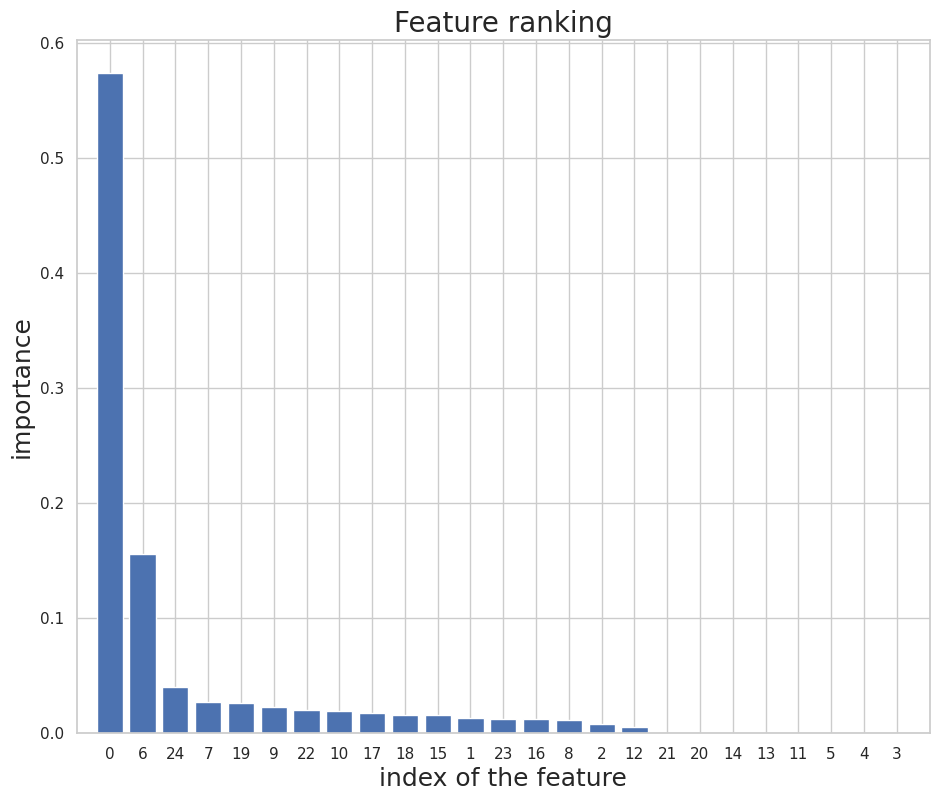

Cycle        0.573804
Sensor_11    0.155811
Sensor_9     0.039793
Sensor_12    0.027229
Sensor_4     0.026726
Sensor_14    0.022679
Sensor_7     0.020282
Sensor_15    0.019422
Sensor_21    0.017555
Sensor_3     0.016199
dtype: float64


In [27]:
# graph feature importance
import matplotlib.pyplot as plt
importances = simple_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns
f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X.shape[1]), indices) #feature_names, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 18)
plt.show()
# list feature importance
important_features = pd.Series(data=simple_rf.feature_importances_,index=X.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features.head(10))

#### Cross Validation and Hyper-Parameters

By means of cross validation and hyper-parameter search, we
can try to obtain a better regression model based on RandomForest.

In [29]:
from sklearn.model_selection import GroupKFold, GridSearchCV

rf = ensemble.RandomForestRegressor(n_estimators=100)

# to avoid having same UnitNumber in both sets
cv = GroupKFold(5)

param_grid = { "min_samples_leaf" : [2, 10, 25, 50, 100],
               "max_depth" : [7, 8, 9, 10, 11, 12]}

optimized_rf = GridSearchCV(estimator=rf,
                            cv = cv,
                            param_grid=param_grid,
                            scoring='neg_mean_squared_error',
                            verbose = 1,
                            n_jobs = -1)

optimized_rf.fit(X, y, groups = train_df.UnitNumber)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=GroupKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [7, 8, 9, 10, 11, 12],
                         'min_samples_leaf': [2, 10, 25, 50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [30]:
y_test_pred = optimized_rf.predict(X_test)
print("[Test] Optimized RF Mean Squared Error: ", mean_squared_error(y_test, y_test_pred))
print("[Test] Optimized RF Mean Absolute Error: ", mean_absolute_error(y_test, y_test_pred))
print("[Test] Optimized RF r-squared: ", r2_score(y_test, y_test_pred))

[Test] Optimized RF Mean Squared Error:  1667.1247253973008
[Test] Optimized RF Mean Absolute Error:  30.8293659096492
[Test] Optimized RF r-squared:  0.5207191908422365


#### Other Models: Gradient Boosting

Gradient Boosted regression and classification are some of the
best performing model for a variety of tasks, let us see if they
can also be applied to this dataset.



In [31]:
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()

# to avoid having same UnitNumber in both sets
cv = GroupKFold(5)

param_grid = { "alpha" : [.75, .9],
               "n_estimators" : [500],
               "learning_rate" :  [.01],
                "max_depth" : [4, 5, 6]
             }

optimized_gb= GridSearchCV(estimator=gb,
                            cv = cv,
                            param_grid=param_grid,
                            scoring='neg_mean_squared_error',
                            verbose = 1,
                            n_jobs = -1)

optimized_gb.fit(X, y, groups = train_df.UnitNumber)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=GroupKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'alpha': [0.75, 0.9], 'learning_rate': [0.01],
                         'max_depth': [4, 5, 6], 'n_estimators': [500]},
             scoring='neg_mean_squared_error', verbose=1)

In [32]:
y_test_pred = optimized_gb.predict(X_test)
print("[Test] Optimized GB Mean Squared Error: ", mean_squared_error(y_test, y_test_pred))
print("[Test] Optimized GB Mean Absolute Error: ", mean_absolute_error(y_test, y_test_pred))
print("[Test] Optimized GB r-squared: ", r2_score(y_test, y_test_pred))

[Test] Optimized GB Mean Squared Error:  1654.7058681822075
[Test] Optimized GB Mean Absolute Error:  30.65224080053392
[Test] Optimized GB r-squared:  0.5242894815614544


#### Exercise: Train Another Cross Validated Model

Based on the previous examples, use cross validation to find a good
set of hyper-parameters and benchmark on the test dataset another scikit-learn regression model ([see documentation](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)), for example choose between:
1. `sklearn.svm.SVR`: [Epsilon-Support Vector Regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR)
2. `sklearn.neural_network.MLPRegressor` : [Multilayer Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)
3. **Advanced Track**: use `GradientBoostingRegressor` but add some engineering features in order to try to improve the previous result (e.g. moving averages and standard deviations of features)

In [ ]:
# space for the exercise solution

### Recurrent Neural Network Model for Regression

All the previous machine learning model can only take tabular data, i.e.
features at a given timestep $t$. Information about the previous time
step can only be include by means of clever feature engineering.

Deep Neural Networks, in particular Recurrent architectures such
as LSTM [[6,7]](#References), can be used
to automatically learn feature transformation on sequence data
for a given task.

Here, a basic example of training a LSTM based model for
predicting the RUL is provided, based on
the Keras-based implementation from [[2]](#References).

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# define path to save model
model_path = 'regression_model.h5'

In [ ]:
# pick a large window size of 50 cycles
seq_length = 50

# generator to reshape features into (samples, time steps, features)
def gen_sequence(unit_number_df, seq_length = seq_length, seq_cols = features):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one unit number I put all the rows in a single matrix
    data_matrix = unit_number_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example UnitNumber 1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

# test, it has to be 142 (192-seq_length)
val=list(gen_sequence(X[train_df['UnitNumber']==1]))
print(len(val))


In [ ]:
# generator for the sequences
# transform each UnitNumber
# of the train dataset in a sequence
seq_gen = (list(gen_sequence(X[train_df['UnitNumber']== un]))
           for un in train_df['UnitNumber'].unique())

# convert sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

In [ ]:
# function to generate labels
def gen_labels(unit_number_df, seq_length = seq_length,
               label = ["target_RUL"]):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]]
    data_matrix = unit_number_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['UnitNumber'] == un])
             for un in train_df['UnitNumber'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

In [ ]:
# Next, we build a deep network.
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units.
# Dropout is also applied after each LSTM layer to control overfitting.
# Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))

# feel free to change the learning rate and experiment
optimizer = keras.optimizers.RMSprop(learning_rate=0.01, rho=0.9)

model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mae'])

print(model.summary())

In [ ]:
# fit the network
history = model.fit(seq_array, label_array,epochs=50, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
)

In [ ]:
history.history

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(10,10))

axs[0].plot(history.history['mae'])
axs[0].plot(history.history['val_mae'])
axs[0].set_title('model MAE')
axs[0].legend(['train', 'test'], loc='upper right')
axs[0].set_xlabel('epoch')


axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model MSE (loss)')
axs[1].legend(['train', 'test'], loc='upper right')
axs[1].set_xlabel('epoch')

y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y = label_array
print("[Train] LSTM Regression Mean Squared Error: ", mean_squared_error(y, y_pred))
print("[Train] LSTM Regression Mean Absolute Error: ", mean_absolute_error(y, y_pred))
print("[Train] LSTM Regression r-squared: ", r2_score(y, y_pred))

#### Test Set Evaluation

The real world performance is hard to estimate, but better evaluate over the set
of data that has not been used for training.

In [ ]:
# pick the last sequence for each id in the test data
sequence_cols = features
seq_array_test_last = [X_test[test_df['UnitNumber']==un][sequence_cols].values[-seq_length:]
                       for un in test_df['UnitNumber'].unique() if len(test_df[test_df['UnitNumber']== un]) >= seq_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# similarly, we pick the labels
y_mask = [len(test_df[test_df['UnitNumber']==un]) >= seq_length for un in test_df['UnitNumber'].unique()]
label_array_test_last = test_df.groupby('UnitNumber')['target_RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

print(seq_array_test_last.shape)
print(label_array_test_last.shape)

In [ ]:
import os
# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path)

    y_pred_test = estimator.predict(seq_array_test_last, batch_size=200)
    y_true_test = label_array_test_last

In [ ]:
print("[Test] LSTM Regression Mean Squared Error: ", mean_squared_error(y_true_test, y_pred_test))
print("[Test] LSTM Regression Mean Absolute Error: ", mean_absolute_error(y_true_test, y_pred_test))
print("[Test] LSTM Regression r-squared: ", r2_score(y_true_test, y_pred_test))

In [ ]:
# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y_pred_test, color="blue")
ax.plot(y_true_test, color="green")
ax.set_title('prediction on unseen data')
ax.set_ylabel('RUL value')
ax.set_xlabel('row')
ax.legend(['predicted', 'actual data'], loc='lower left')

### Predict Failures using Classification

**Will the unit fail within a certain time-frame (i.e. number of cycles)?**

This can be though of a classification problem,
where the boolean target is whether the unit will fail
within the next $n$ timesteps (e.g. 15 cycles).

The goal in a (soft) classification problem is to find a function
$f_C(\boldsymbol{x})$ that approximates probabilities of belonging
to a set of classes or categories $y$. The
target in this problem will be the whether the engine
will fail in the next 15 timesteps, while $\boldsymbol{x}$
will be the input features (e.g. sensor readings).

To measure the goodness of our classification function, we need
to define and score function, which will be also the loss
function for the machine learning techniques considered.
We will be considering the binary cross entropy:
$$ \textrm{BCE} = \sum_{i=1}^{n} (y \log \left(f_C(\boldsymbol{x})\right) - (1-y) y \log \left(1-f_C(\boldsymbol{x}) \right )$$
which is one of the most common losses used for binary
classification, and could be extended also to the
multiclass/multilabel problem.


In [ ]:
from sklearn.model_selection import train_test_split

# we can keep the same input features, we have only to compute the
# new target (we will only use the train set for classification)
cycles = 15
train_df['Target_15_Cycles'] = np.where(train_df['target_RUL'] <= cycles, 1, 0 )

y_clf = train_df["Target_15_Cycles"]

X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X, y_clf, test_size=0.2, random_state=1234)

train_df.tail()

#### Gradient Boosting for Classification

Similarly to what was done for the regression problem and given
the good performance observed for the Gradient Boosting model,
we will train a gradient boosted model for classification.


In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier()

# to avoid having same UnitNumber in both sets
cv = KFold(3)

param_grid = { "n_estimators" : [500],
               "learning_rate" :  [.01],
                "max_depth" : [6]
             }

optimized_gb_clf = GridSearchCV(estimator=gb_clf,
                            cv = cv,
                            param_grid=param_grid,
                            verbose = 1,
                            n_jobs = -1)

optimized_gb_clf.fit(X_clf_train, y_clf_train)

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report

y_test_clf_proba = optimized_gb_clf.predict_proba(X_clf_test)[:, 1]
y_test_clf_pred = optimized_gb_clf.predict(X_clf_test)

print("Confusion Matrix:")
print(confusion_matrix(y_clf_test,y_test_clf_pred))
print("Gradient Boosting Classifier Accuracy: "+"{:.1%}".format(accuracy_score(y_clf_test,y_test_clf_pred)));
print("Gradient Boosting Classifier Precision: "+"{:.1%}".format(precision_score(y_clf_test,y_test_clf_pred)));
print("Gradient Boosting Classifier Recall: "+"{:.1%}".format(recall_score(y_clf_test,y_test_clf_pred)));
print("Classification Report:")
print(classification_report(y_clf_test,y_test_clf_pred))


In [ ]:
from sklearn import metrics

fpr, tpr, threshold = metrics.roc_curve(y_clf_test,y_test_clf_proba)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots()

ax.set_title('Receiver Operating Characteristic Curve')
ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax.legend(loc = 'lower right')
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')


#### Advanced Exercise: Recurrent Neural Network Model for Classification

Based on the previous regression example and the classification
target, train and evaluate a model for predictive
maintenance classification using a LSTM.

In [ ]:
# space for the exercise solution

In [ ]:
# more space for the exercise solution

## References

This notebook is heavily based on these resources on the topic:

- [1] [*Predictive Maintenance Template*](https://gallery.azure.ai/Collection/Predictive-Maintenance-Template-3)  by Microsoft Azure ML Team
- [2] [*Predictive Maintenance using LSTM*](https://github.com/umbertogriffo/Predictive-Maintenance-using-LSTM) by Umberto Griffo
- [3] [*Predictive Maintenance ML (IIOT)*](https://www.kaggle.com/billstuart/predictive-maintenance-ml-iiot) by Bill Stuart

The dataset used was provided by NASA:

- [4] A. Saxena and K. Goebel (2008). [*Turbofan Engine Degradation Simulation Data Set*](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan), NASA Ames Prognostics Data Repository, NASA Ames Research Center, Moffett Field, CA


Other resources and tutorials on Predictive Maintenance:

- [5] [*Predictive Maintenance Modelling Guide*](https://gallery.azure.ai/Collection/Predictive-Maintenance-Implementation-Guide-1) by Fidan Boyly Uz

Two good really good posts on the concept and usefulness of Recurrent Neural Networks for sequence data:

- [6] [*The Unreasonable Effectiveness of Recurrent Neural Networks*](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) by Andrej Karpathy

- [7] [*Understanding LSTM Networks*](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Christopher Olah

This recent papers (with code) use this dataset in combination
with more advanced Deep Learning architectures and data augmentation
to achieve state of the art (SOTA):

- [8] S. Theng et al. [*Long short-term
memory network for remaining useful life estimation*](https://ieeexplore.ieee.org/document/7998311) in Proc. IEEE International Conference on Prognostics and Health

- [9] L. Jayasinghe et al. [*Temporal Convolutional Memory Networks for
Remaining Useful Life Estimation of Industrial Machinery*](https://github.com/LahiruJayasinghe/RUL-Net) in IEEE International Conference on Industrial Technology (ICIT2019)

Not many books on this topic, there is a book on ML for IOT (free 1 month subscription online), yet the
advanced ML chapter do not include specific IoT applications:

- [10] [Hands-On Artificial Intelligence for IoT](https://www.packtpub.com/big-data-and-business-intelligence/hands-artificial-intelligence-iot?utm_source=github&utm_medium=repository&utm_campaign=9781788836067) by Amita Kapoor (2019)